In [ ]:
import cv2
import PIL
from skimage.transform import resize
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization,LeakyReLU, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate,Add
from tensorflow.keras.preprocessing.image import load_img, img_to_array,array_to_img
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import struct
import scipy.misc
import os
from numpy import expand_dims

In [ ]:
class WeightReader:
	def __init__(self, weight_file):
		# 가중치 파일을 바이너리 형식으로 열고, 파일 헤더 정보를 읽어들입니다.
		with open(weight_file, 'rb') as w_f:
			# 첫 3개의 정수는 major, minor, revision으로 이들은 파일 버전을 나타냅니다.
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))

			# 파일 버전이 2 이상인 경우에는 두 개의 정수를 더 읽어들입니다.
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)

			# major나 minor가 1000을 초과하는 경우에는 transpose를 True로 설정합니다.
			transpose = (major > 1000) or (minor > 1000)

			# 파일의 나머지 부분을 모두 읽어들입니다.
			binary = w_f.read()

		# offset은 현재 파일에서 읽고 있는 위치를 나타냅니다.
		self.offset = 0
		# 읽어들인 바이너리 데이터를 float32 타입으로 변환하여 all_weights에 저장합니다.
		self.all_weights = np.frombuffer(binary, dtype='float32')

	# size만큼 바이트를 읽어들이는 함수입니다.
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	# 모델에 가중치를 로드하는 함수입니다.
	def load_weights(self, model):
		# 모델의 각 레이어에 대하여
		for i in range(106):
			try:
				# 'conv_{i}' 레이어를 찾습니다.
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				# i가 [81, 93, 105]에 속하지 않는 경우에는 배치 정규화 레이어에 대한 가중치를 로드합니다.
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					# bias, scale, mean, variance에 해당하는 가중치를 각각 읽어들입니다.
					beta  = self.read_bytes(size) # 편향
					gamma = self.read_bytes(size) # 스케일
					mean  = self.read_bytes(size) # 평균
					var   = self.read_bytes(size) # 분산
					weights = norm_layer.set_weights([gamma, beta, mean, var])  # 분산, 편향, 평균, 스케일 순서로 가중치 설정

				# conv 레이어의 가중치가 두 개 이상인 경우, bias와 kernel에 대한 가중치를 로드합니다.
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))  # 편향에 대한 가중치
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))  # 커널에 대한 가중치
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))  # 커널 가중치의 형태를 재구성
					kernel = kernel.transpose([2,3,1,0])  # 가중치를 transpose
					conv_layer.set_weights([kernel, bias])  # conv 레이어에 가중치를 설정
				else:
					# conv 레이어의 가중치가 하나인 경우, kernel에 대한 가중치만 로드합니다.
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))  # 커널에 대한 가중치
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))  # 커널 가중치의 형태를 재구성
					kernel = kernel.transpose([2,3,1,0])  # 가중치를 transpose
					conv_layer.set_weights([kernel])  # conv 레이어에 가중치를 설정
			except ValueError:
				print("no convolution #" + str(i))  # 해당 번호의 conv 레이어가 없는 경우 메시지를 출력

	# offset을 0으로 재설정하는 함수입니다.
	def reset(self):
		self.offset = 0


In [ ]:
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		# 블록 내의 마지막-1번째 레이어가 skip 연결이 있다면 그 위치를 저장합니다
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		# Darknet은 패딩을 왼쪽과 위쪽에 선호하기 때문에 stride가 1보다 큰 경우 특별한 패딩을 적용합니다
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x)
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   # 패딩 설정: stride가 1보다 큰 경우 'valid'로 설정하고 그렇지 않은 경우 'same'으로 설정
				   padding='valid' if conv['stride'] > 1 else 'same',
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		# 배치 정규화를 수행하는 레이어
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		# 활성화 함수로 LeakyReLU를 사용하는 레이어
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	# skip 연결이 있다면 해당 위치의 텐서와 현재 텐서를 더합니다
	return Add()([skip_connection, x]) if skip else x

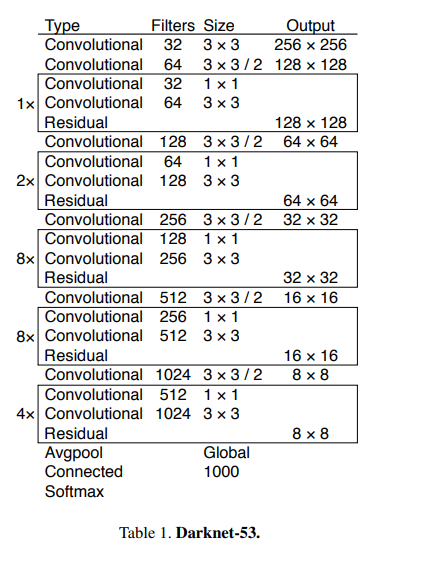

In [ ]:
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

In [ ]:
yolov3 = make_yolov3_model()

In [ ]:
# yolo v3 model define
yolov3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv_0 (Conv2D)             (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 bnorm_0 (BatchNormalizatio  (None, None, None, 32)       128       ['conv_0[0][0]']              
 n)                                                                                               
                                                                                                  
 leaky_0 (LeakyReLU)         (None, None, None, 32)       0         ['bnorm_0[0][0]']       

In [ ]:
# !unzip

In [ ]:
weight_reader = WeightReader('/content/drive/MyDrive/nvidia_ai_academy/영상처리과정/yolo의 사본/yolov3.weights')

In [ ]:
# YOLO v3 모델 정의하기
yolov3 = make_yolov3_model()

# 가중치 로드하기
# '/content/yolov3.weights' 경로에서 가중치를 읽어옵니다.
weight_reader = WeightReader('/content/drive/MyDrive/nvidia_ai_academy/영상처리과정/yolo의 사본/yolov3.weights')

# 가중치 설정하기
# weight_reader를 이용해 yolov3 모델에 가중치를 설정합니다.
weight_reader.load_weights(yolov3)

# 모델을 파일로 저장하기
# 'model.h5'라는 이름으로 모델을 저장합니다.
yolov3.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


loading weights of convolution #91
loading weights of convolution #92
loading weights of convolution #93
no convolution #94
no convolution #95
loading weights of convolution #96
no convolution #97
no convolution #98
loading weights of convolution #99
loading weights of convolution #100
loading weights of convolution #101
loading weights of convolution #102
loading weights of convolution #103
loading weights of convolution #104
loading weights of convolution #105


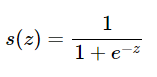

In [ ]:
# sigmoid funtion
def _sigmoid(x):
  return 1./ (1 + np.exp(-x))

In [ ]:
def load_image_pixels(filename, shape):
  # 이미지를 로드하여 그 크기를 가져옵니다.
  image = load_img(filename)
  width, height = image.size

  # 필요한 크기로 이미지를 로드합니다.
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # 그레이스케일 이미지 정규화
  # 이미지의 픽셀 값을 0과 1 사이로 변환하여 데이터를 정규화합니다.
  image = image.astype('float32')
  image /= 255.0

  # 차원을 추가하여 샘플이 하나 있다는 것을 표시합니다.
  # 모델에 이미지를 전달할 때는 배치로 전달해야 하므로 차원을 하나 추가합니다.
  image = expand_dims(image, 0)
  return image, width, height


In [ ]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    # 객체일 확률
    self.objness = objness
    # 각 클래스에 속할 확률
    self.classes = classes
    # 초기 레이블과 점수를 -1로 설정
    self.label = -1
    self.score = -1

  def get_label(self):
    # 레이블이 아직 설정되지 않았다면, 가장 확률이 높은 클래스를 레이블로 설정
    if self.label == -1:
      self.label = np.argmax(self.classes)
    return self.label

  def get_score(self):
    # 점수가 아직 설정되지 않았다면, 레이블 클래스의 확률을 점수로 설정
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.score

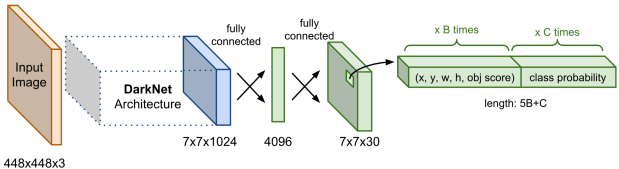

In [ ]:
'''
 네트워크 출력을 디코딩 하는 함수
 각 출력박스를 바운드 박스 객체로 변환
 네트워크 출력, 앵커 ,객체 입력값, 네크워크 높이 및 네트워크의 너비를 매개변수로 받는다.
 출력은 바운딩 박스의 리스트 , 각 x, y 좌표, 객체일 확률, 클래스 확률값들이 나옴
'''

# 네트워크 출력을 디코딩하는 함수
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4번째 요소는 objectness 점수입니다.
			objectness = netout[int(row)][int(col)][b][4]
			# objectness가 임계값보다 낮으면 해당 박스를 무시합니다.
			if(objectness.all() <= obj_thresh): continue
			# 처음 4개 요소는 x, y, w, h 입니다.
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # 중심 위치, 단위: 이미지 너비
			y = (row + y) / grid_h # 중심 위치, 단위: 이미지 높이
			w = anchors[2 * b + 0] * np.exp(w) / net_w # 단위: 이미지 너비
			h = anchors[2 * b + 1] * np.exp(h) / net_h # 단위: 이미지 높이
			# 마지막 요소들은 클래스 확률입니다.
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes



In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w , net_h, net_w):
    new_w = net_w # offset계산후 조정
    new_h = net_h # offset계산후 조정
    x_offset, x_scale = (net_w - new_w)/2./net_w , float(new_w)/net_w  # offset계산후 조정
    y_offset ,y_scale = (net_h - new_h)/2./net_h , float(new_h)/net_h  # offset계산후 조정

    # offset 계산 필요 : 원본 이미지 와 모델의 아웃풋 좌표값의 오차를 조정해주는 값
    for i in range(len(boxes)):
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:

#  IOU 계산
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a  # 시작점과 끝점
    x3, x4 = interval_b  # 시작점과 끝점
    '''
    x1 = 3 , x2 = 8 A구간
    case 1 :
    구간 B가 구간 A의 앞 부분과 겹치는 경우 (x3 = 1, x4 = 5)
    '''
    if x3 < x1:
        if x4 < x1 :
          return 0
        else:
            # 얼마나 겹쳤는지
            return min(x2, x3) - x1
    else:
      if x2 < x3:
            return 0
      else:
            return min(x2,x4) - x3

In [ ]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin , box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin , box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h

    w1 , h1 = box1.xmax - box1.xmin , box1.ymax - box1.ymin
    w2 , h2 = box2.xmax - box2.xmin , box2.ymax - box2.ymin

    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            # 정렬된 바운딩 박스들을 순회하면서 각 바운딩 박스에 대해 다양한 조건을 통과
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            # 현재 선택된 바운딩 박스와 겹치는 모든 바운딩 박스를 찾자
            for j in range(i+i, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:                   boxes[index_j].classes[c]  = 0

In [ ]:

# 임계값을 초과하는 박스만 들고오기
def get_boxes(boxes, label,thresh):
    v_boxes ,v_labels, v_scores = list(), list(), list()
    for box in boxes:
        # 모든 레이블 순회
        for i in range(len(label)):
            #이 레이블에 대해 임계값이 충분히 큰지 확인
            if box.classes[i] >thresh:
                v_boxes.append(labels[i])
                v_labels.append(labels[i])
                v_scores.append(box.classes[i] * 100)
    return v_boxes, v_labels, v_scores

In [ ]:
# 앵커 정의
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# 감지된 객체에 대한 확률 임계값 정의
class_threshold = 0.6

# 레이블 정의
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator"	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    data = plt.imread(filename) # 이미지 불러오기
    plt.imshow(data)
    ax = plt.gca() # 축 지정
    #각각의 바운딩 박스에 대해 그림을 그림
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        #좌표 가져오기
        y1,x1,y2,x2 = box.ymin, box.xmin, box.ymax, box.xmax

        #박스 그리기
        width , height = x2 - x1 , y2 - y1

        # 좌상단 x1,y1 , 가로, 세로길이, 사각형 박스에 색깔 채우기 X, 선은 흰색
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        # 라벨과 점수 표시 하기
        label = f'{v_labels[i]}({str(int(v_scores[i]))})'
        plt.text(x1,y1, label, color='white')
    plt.show()

Saving 20080403000901_0.jpg to 20080403000901_0 (2).jpg
1/1 [==============================] - 2s 2s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 81.5743088722229
person 96.86573147773743
person 76.31954550743103
person 60.83750128746033
person 66.75935387611389
person 80.0550103187561
person 74.39209222793579
person 68.12958121299744
person 65.1219129562378
person 64.71173763275146
person 77.58236527442932
person 62.39701509475708
person 80.93978762626648
person 74.34108257293701
person 83.18269848823547
person 71.20836973190308
person 61.12256050109863
person 71.59673571586609
person 60.052841901779175
person 72.54659533500671
person 86.16383671760559
person 60.1631224155426
person 60.27774214744568
person 67.11551547050476
person 84.76915955543518
person 72.57322669029236
person 86.72849535942078
person 89.38377499580383
person 73.2825517654419
person 83.44718813896179
person 72.55990505218506
person 96.14337682723999
person 88.76954913139343
person 91.20609164

AttributeError: 'str' object has no attribute 'ymin'

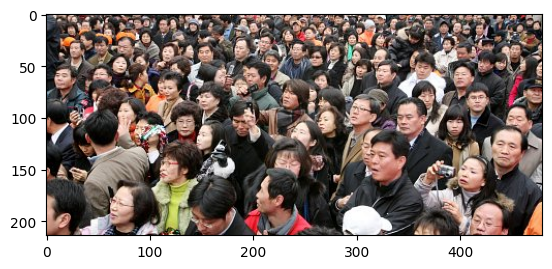

In [ ]:
from google.colab import files
upload = files.upload()

for fn in upload.keys():
    photo_filename = fn
    # 모델 입력 크기 설정
    input_w, input_h = 416,416

    # 이미지 로드, 해당 이미지 크기를 변경 및 전처리 하여 픽셀 정보 값 들고오기(np)
    image, image_w, image_h = load_image_pixels(photo_filename,(input_w,input_h))

    #예측 실행
    yhat = yolov3.predict(image)

    #예측 결과의 배열 형태를 출력
    print([a.shape for a in yhat])

    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0] , anchors[i], class_threshold, input_h,input_w)
    # 바운딩 박스 크기를 이미지의 실제 크기와 맞춰 조정
    correct_yolo_boxes(boxes , image_h, image_w, input_h, input_w)
    # NMS
    do_nms(boxes, 0.5)

    # 박스 세부 정보 받아오기
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    for i in range(len(v_boxes)):
        print(v_labels[i] , v_scores[i])
    # 시각화
    draw_boxes(photo_filename, v_boxes,v_labels, v_scores)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

capture = cv2.VideoCapture('/content/video/video-capture-images.mp4')  # 비디오 파일 경로를 전달합니다.

while True:
    ret, frame = capture.read()  # capture.read() 함수를 호출하여 프레임을 읽어옵니다.

    if not ret:  # ret이 False이면 프레임을 읽어올 수 없습니다.
        break

    cv2_imshow(frame)  # 읽어온 프레임을 표시합니다.

    if cv2.waitKey(1) & 0xFF == ord('q'):  # 'q' 키를 누르면 루프를 종료합니다.
        break

capture.release()  # 비디오 캡처 객체를 해제합니다.
cv2.destroyAllWindows()  # 모든 창을 닫습니다.

In [ ]:
video_path = '/content/video/키즈현대 - 신호등 없는 횡단보도 보행시 위험상황.mp4'
video_capture = cv2.VideoCapture(video_path)

In [ ]:
want_resolution = 720
frame_directory = 'new_image'
frame_cnt = 0
if video_capture.isOpened():
    while True:
        # 영상에서 프레임 마다 짜르기
        ret , frame = video_capture.read()
        if ret:
            frame_height, frame_width , frame_channels = frame.shape

            #가로 세로 비율을 유지하며 새로운 너비를 계산하기
            new_width = int(frame_width * want_resolution / frame_height)

            frame = cv2.resize(frame, (new_width, want_resolution))

            if(int(video_capture.get(1)) % 60 == 0):    # 만약 모든 프레임 저장하고 싶다 -> if 문 삭제
                cv2.imwrite(f'{frame_directory}/{frame_cnt}.png',frame)
                frame_cnt += 1
        else:
            break
    print(f'저장된 이미지의 너비:{new_width}')
    print(f'저장된 프레임: {frame_cnt}')

#  비디오 캡쳐 객체 해제
video_capture.release()
